In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()


In [3]:
#Todos los datos están juntos, los saltos de linea están representados por "\n", entonces construye un vector con comas en aquellos saltos de lineas
lines = data.split("\n")
#Header es la linea 0, separa a los objetos de esa linea por comas
header = lines[0].split(",")

#Lo siguiente considera a todas las lineas menos a la primera (el encabezado)
lines = lines[1:]

#Imprime todos los encabezados
print(header)

#Número de datos de cada tipo
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np

#Se crea una matriz de ceros del mismo tamaño de todas las lineas de la tabla (tabla linesX1) para guardar las temperaturas
temperature = np.zeros((len(lines),))
presion = np.zeros((len(lines),))

#se crea una matriz de ceros de linesXheader-1
raw_data = np.zeros((len(lines), len(header) - 1))

#Aquí i representa el índice que va hasta el número de elemento de lines
#Mientras que line representa el elemento la linea i de la misma lista lines
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]] #aquí se leen solo los valores de las variables metereológicas (una fila por ciclo), separándolas por comas
    temperature[i] = values[1] #Se guarda la temperatura que es el elemento 1 del vector de values
    raw_data[i, :] = values[:] #Se cuarda la matriz de todas las variables metereológicas de cada momento
    
    
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]] #aquí se leen solo los valores de las variables metereológicas (una fila por ciclo), separándolas por comas
    presion[i] = values[0] #Se guarda la temperatura que es el elemento 1 del vector de values
    raw_data[i, :] = values[:] #Se cuarda la matriz de todas las variables metereológicas de cada momento
    

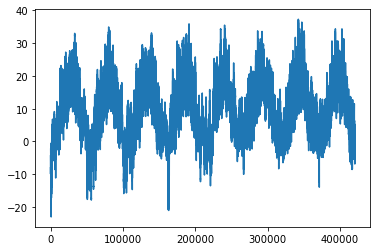

In [5]:
#Se grafica la serie de tiempo de todas las temperaturas (datos tomados cada 10 minutos)

from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)
plt.plot(range(len(presion)), presion, color = 'red')

1) SE CONSTRUYEN LOS DATASETS

In [85]:
from tensorflow import keras
import numpy as np


#Aquí los datos se toman de 6 en 6, como cada dato de la temperatura es tomado cada 10 minutos, ahora será cada hora
sampling_rate = 1 

#El tamaño de la secuencia será de 4 días 96 hrs. (la ventana de observación)
sequence_length = 96

#Este es delay (la diferencia de los datos input con los target)
delay = sampling_rate * (sequence_length + 10 - 1)

#Se introduce el tamaño del batch  
batch_size = 1000



#Se crean las muestras para el entrenamiento, validación y el test
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [108]:
import pandas as pd

traindat = pd.DataFrame(train_dataset)
valdat = pd.DataFrame(val_dataset)
testdat = pd.DataFrame(test_dataset)

2) SE IMPLEMENTA EL MODELO

In [146]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation, LSTM, Conv1D
from keras.callbacks import ModelCheckpoint


#Se crea un modelo Long Short Term Memory
model = Sequential()

#Creamos una red LSTM con 16 bloques de memoria
model.add(LSTM(32, batch_input_shape=(None,None,14)))
model.add(Dense(5))
model.add(Dense(1))

model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 32)                6016      
                                                                 
 dense_69 (Dense)            (None, 5)                 165       
                                                                 
 dense_70 (Dense)            (None, 1)                 6         
                                                                 
Total params: 6187 (24.17 KB)
Trainable params: 6187 (24.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
#Compilamos y corremos el modelo usando como métrica el error cuadrático medio (que hay que disminuir)

model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
        epochs=10,
        validation_data = val_dataset)


print(f"LA MAE con los Datos Test: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
211/211 [==============================] - 90s 417ms/step - loss: 2.8395 - mae: 1.2438 - val_loss: 2.2027 - val_mae: 1.1055
Epoch 2/10
211/211 [==============================] - 88s 417ms/step - loss: 2.6124 - mae: 1.1930 - val_loss: 2.2647 - val_mae: 1.0544
Epoch 3/10
211/211 [==============================] - 88s 415ms/step - loss: 2.6046 - mae: 1.1943 - val_loss: 2.9000 - val_mae: 1.4206
Epoch 4/10
211/211 [==============================] - 88s 417ms/step - loss: 2.5517 - mae: 1.1770 - val_loss: 2.1295 - val_mae: 1.0433
Epoch 5/10
211/211 [==============================] - 87s 414ms/step - loss: 2.5806 - mae: 1.1905 - val_loss: 2.3200 - val_mae: 1.1537
Epoch 6/10
211/211 [==============================] - 87s 411ms/step - loss: 2.5478 - mae: 1.1787 - val_loss: 2.6570 - val_mae: 1.3154
Epoch 7/10
211/211 [==============================] - 87s 413ms/step - loss: 2.5589 - mae: 1.1839 - val_loss: 2.2823 - val_mae: 1.0885
Epoch 8/10
211/211 [==============================] - 8

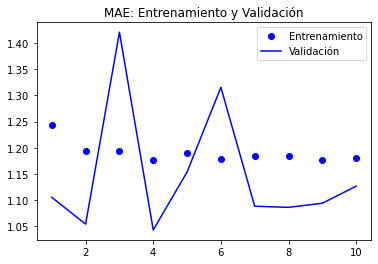

In [89]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Entrenamiento")
plt.plot(epochs, val_loss, "b", label="Validación")
plt.title("MAE: Entrenamiento y Validación")
plt.legend()
plt.show()

3) Prueba ahora como datos de entrada las demás variables como presión y las demás.

In [142]:

#Aquí los datos se toman de 6 en 6, como cada dato de la temperatura es tomado cada 10 minutos, ahora será cada hora
sampling_rate = 1 

#El tamaño de la secuencia será de 4 días 96 hrs. (la ventana de observación)
sequence_length = 96

#Este es delay (la diferencia de los datos input con los target)
delay = sampling_rate * (sequence_length + 10 - 1)

#Se introduce el tamaño del batch  
batch_size = 1000



#Se crean las muestras para el entrenamiento, validación y el test
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

train_dataset = keras.utils.timeseries_dataset_from_array(
    data = temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data = temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data = temperature[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [151]:
#Se crea un modelo Long Short Term Memory

#inputs = keras.Input(shape=(sequence_length, temperature.shape))
model2 = Sequential()

#Creamos una red LSTM con 16 bloques de memoria
model2.add(LSTM(32, batch_input_shape=(None,None,14)))
model2.add(Dense(5))
model2.add(Dense(1))

model2.summary()

#Compilamos y corremos el modelo usando como métrica el error cuadrático medio (que hay que disminuir)

model2.compile(optimizer="Adam", loss="mse", metrics=["mae"])
history = model2.fit(train_dataset,
        epochs=10,
        validation_data = val_dataset)


print(f"LA MAE con los Datos Test: {model.evaluate(test_dataset)[1]:.2f}")

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 32)                6016      
                                                                 
 dense_73 (Dense)            (None, 5)                 165       
                                                                 
 dense_74 (Dense)            (None, 1)                 6         
                                                                 
Total params: 6187 (24.17 KB)
Trainable params: 6187 (24.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


ValueError: in user code:

    File "C:\g\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\g\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\g\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\g\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "C:\g\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\g\lib\site-packages\keras\src\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_68' (type Sequential).
    
    Input 0 of layer "lstm_61" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)
    
    Call arguments received by layer 'sequential_68' (type Sequential):
      • inputs=tf.Tensor(shape=(None, None), dtype=float64)
      • training=True
      • mask=None


TypeError: '_BatchDataset' object is not subscriptable